# **Socio-emotional Coping through *Music Listening*: LGBM Regression**
Lindsay Warrenburg  
lindsay.a.warrenburg@gmail.com  
Final version: December 20, 2020

### This script describes a machine learning approach to investigate how people used *music listening* to cope with the social and emotional stress of the coronavirus crisis. 

- It shows how the data do not meet linearity assumptions and therefore require a non-linear method
- The results of the LGBM regression model are presented, along with SHAP value plots assessing feature importance.

In [1]:
import numpy as np, pandas as pd, os, sys, itertools, seaborn as sns, re, warnings, math, scipy as sp, lightgbm as lgb, sklearn, shap, matplotlib.pyplot as plt, matplotlib.cm as cm, statsmodels.stats.api as sms, statsmodels.api as sm
from sklearn import preprocessing, metrics, manifold
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer, confusion_matrix, plot_confusion_matrix, classification_report 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from IPython.display import Image, HTML
from matplotlib.ticker import NullFormatter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline
plt.rcParams['figure.figsize'] = (14,4)
warnings.filterwarnings(action='ignore')
%run Coronavirus_Music_Functions.ipynb

### **Data**

In [2]:
all_data = pd.read_csv("cleaned_data.csv")
all_data.drop(columns=['Demographics_General_Gender','date','ESM_ID','ID'], inplace=True)
original_n = len(all_data)
print(original_n, "total participants in the survey.")

5113 total participants in the survey.


In [3]:
# only keep people in listening and both groups
data = all_data[all_data['Survey Info_Group'].isin(['both','listening only'])].reset_index(drop=True)
new_n = len(data)
print(original_n-new_n, "people were removed because they didn't answer any of the listening questions.")
data['Survey Info_Group'].value_counts()

441 people were removed because they didn't answer any of the listening questions.


both              3003
listening only    1669
Name: Survey Info_Group, dtype: int64

In [4]:
# drop performance and formats and Survey Info_Group
col_list = [c for c in data.columns if not c.startswith('Making Music_') and '_Formats_' not in c and c != 'Survey Info_Group']
data = data[col_list].reset_index(drop=True)

In [5]:
# rename columns
data.rename(columns={"Country_Country Name": "Country",
                     'Demographics_General_Gender_binary': 'Demographics_General_Gender',
                     'Activities_Sexual Activity':'Activities_Sex'
                    }, inplace=True, errors="raise")

data.columns = data.columns.str.replace(r'^.*Music Listening_', '')
data = data.reindex(sorted(data.columns), axis=1).reset_index(drop = True)

In [6]:
# remove prefixes
data.columns = data.columns.str.replace(r'^.*Activities_', '')
data.columns = data.columns.str.replace(r'^.*Country_', '')
data.columns = data.columns.str.replace(r'^.*Demographics_', '')
data.columns = data.columns.str.replace(r'^.*Functions_', '')
data.columns = data.columns.str.replace(r'^.*Hypotheses_', '')
data.columns = data.columns.str.replace(r'^.*Music Engagement_', '')
data.columns = data.columns.str.replace(r'^.*Situations_', '')
data.columns = data.columns.str.replace(r'^.*General_', '')
data.columns = data.columns.str.replace(r'^.*Health_', '')
data.columns = data.columns.str.replace(r'^.*Music_', '')
data.columns = data.columns.str.replace(r'^.*Personality_', '')
data.columns = data.columns.str.replace(r'^.*COVID_', '')

# data.columns.tolist()

In [7]:
# only keep people that answered all of the hypotheses
original_n = len(data)
hypotheses = ['Feel Connected to Others', 'Helps Me Cope', 'Serve as Social Interaction']
data = data.dropna(subset=hypotheses, how='any').reset_index(drop = True)
new_n = len(data)

print(original_n-new_n, "people were removed because they didn't answer at least one of the three hypotheses.")

46 people were removed because they didn't answer at least one of the three hypotheses.


In [8]:
# remove columns with more than 20% missing data
original_columns = data.columns.tolist()

data = remove_columns(data, 20)
new_columns = data.columns.tolist()
columns_with_missing_data = set(original_columns) - set(new_columns)

print("These column(s) were deleted because they contained >20% missing values:")
print(columns_with_missing_data)

1.2 percent of cols with > 20 % missing data
These column(s) were deleted because they contained >20% missing values:
{'Bored'}


In [9]:
# impute missing values by country
normalize_column = 'Country'
cols_to_impute = [x for x in data.columns if x != normalize_column]

for i, column in enumerate(cols_to_impute):
    data[column] = data.groupby(normalize_column, sort = False)[column].apply(lambda x: x.fillna(x.median()))
    
data.reset_index(inplace = True, drop = True)

In [10]:
# average hypotheses columns
cor = data[hypotheses].corr().unstack().sort_values(kind="quicksort", ascending = False)
cor = pd.DataFrame(cor)
cor.columns = ['correlation']
print(cor[cor.correlation < 1], "\n")

data['avg_h'] = (data.loc[:,hypotheses]).mean(axis=1)
print(100*(len(data.loc[data['avg_h'] > 4,:])/len(data)), "% of people who scored > 4")
data = data.drop(columns = hypotheses, axis = 1).reset_index(drop = True)
h_avg = data.pop('avg_h')

                                                         correlation
Serve as Social Interaction Feel Connected to Others        0.720611
Feel Connected to Others    Serve as Social Interaction     0.720611
Helps Me Cope               Feel Connected to Others        0.699969
Feel Connected to Others    Helps Me Cope                   0.699969
Serve as Social Interaction Helps Me Cope                   0.655547
Helps Me Cope               Serve as Social Interaction     0.655547 

55.317769130998705 % of people who scored > 4


In [11]:
# create categorical labels for country (this is NOT ordinal)
c = data.Country.astype('category')
country_dict = dict(enumerate(c.cat.categories))

data['Country'] = data.Country.astype('category').cat.codes

In [12]:
print("FINAL COLUMNS")
data.columns.tolist()

FINAL COLUMNS


['Call People',
 'Cleaning',
 'Cooking',
 'Crafting',
 'Create Online Content',
 'Drugs or Alcohol',
 'Exercise Indoors',
 'Exercise Outdoors',
 'Fashion',
 'Gardening',
 'Learning New Skills',
 'Making Music',
 'Meditating',
 'Music Listening',
 'Online Dating',
 'Photography',
 'Playing Games',
 'Reading Books',
 'Searching for Music Info',
 'Sex',
 'Shopping Online',
 'Social Media',
 'Thinking About Music',
 'Virtual Exhibitions',
 'Visit People in Person',
 'Volunteering',
 'Watching Movies',
 'Watching News',
 'Writing',
 'Country',
 'Confirmed Cases',
 'Confirmed Deaths',
 'Containment Health Index',
 'Economic Support Index',
 'Government Response Index',
 'Stringency Index',
 'Current Place Home',
 'Living Situation-Alone',
 'Living Situation-Child',
 'Living Situation-Elderly',
 'Living Situation-Friend',
 'Living Situation-No Response',
 'Living Situation-Other',
 'Living Situation-Parent',
 'Living Situation-Partner',
 'Living Situation-Pet',
 'Living Situation-Shared',
 'L

In [13]:
data['Country'].map(country_dict).value_counts()

France     848
Italy      800
India      794
Germany    792
USA        788
UK         604
Name: Country, dtype: int64

In [14]:
print("Final data shape:", data.shape)

Final data shape: (4626, 160)


In [15]:
X = data.copy()
X = sm.add_constant(X)
y = h_avg

#### **Linearity Assumptions**

In [16]:
# Multicollinearity
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
len(vif[vif > 5]), vif[vif > 5]

(24,
 Country                                  7.999877e+01
 Confirmed Cases                          6.056199e+02
 Confirmed Deaths                         6.898459e+02
 Containment Health Index                 7.444029e+07
 Economic Support Index                   1.161978e+07
 Government Response Index                7.999730e+07
 Stringency Index                         8.861818e+02
 Work Changed Binary                      6.038350e+00
 City Type-No Response                             inf
 City Type-Rural                                   inf
 City Type-Suburban                                inf
 City Type-Urban                                   inf
 COVID Contact Binary                     6.554485e+01
 Infected with COVID-No Response          7.551432e+01
 Infected with COVID-None                 8.078478e+01
 Infected with COVID-Prefer Not To Say    1.073252e+01
 Making Music-Alone                                inf
 Making Music-Both Alone And Together              inf
 Maki

In [17]:
avg_ols_model = sm.OLS(y, X)
avg_results = avg_ols_model.fit()
avg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  avg_h   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     36.01
Date:                Fri, 18 Dec 2020   Prob (F-statistic):               0.00
Time:                        10:44:16   Log-Likelihood:                -6682.1
No. Observations:                4626   AIC:                         1.367e+04
Df Residuals:                    4471   BIC:                         1.467e+04
Df Model:                         154                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                                              -1.0328      0.978     -1.056      0.291      -2.950       0.885
Call People                                        -0.0254      0.013     -1.961      0.050      -0.051      -9e-06
Cleaning                                            0.0290      0.014      2.097      0.036       0.002       0.056
Cooking                                            -0.0001      0.014     -0.007      0.994      -0.028       0.028
Crafting                                           -0.0210      0.014     -1.550      0.121      -0.048       0.006
Create Online Content                              -0.0186      0.015     -1.259      0.208      -0.048       0.010
Drugs or Alcohol                                   -0.0152      0.015     -0.997      0.319      -0.045       0.015
Exercise Indoors                                   -0.0215      0.013     -1.718      0.086      -0.046       0.003
Exercise Outdoors                                   0.0045      0.011      0.411      0.681      -0.017       0.026
Fashion                                            -0.0157      0.012     -1.285      0.199      -0.040       0.008
Gardening                                           0.0187      0.014      1.341      0.180      -0.009       0.046
Learning New Skills                                -0.0156      0.014     -1.130      0.258      -0.043       0.011
Making Music                                        0.0106      0.016      0.674      0.500      -0.020       0.042
Meditating                                         -0.0059      0.015     -0.400      0.689      -0.035       0.023
Music Listening                                     0.0838      0.015      5.593      0.000       0.054       0.113
Online Dating                                      -0.0227      0.016     -1.408      0.159      -0.054       0.009
Photography                                         0.0131      0.014      0.943      0.346      -0.014       0.040
Playing Games                                      -0.0214      0.013     -1.585      0.113      -0.048       0.005
Reading Books                                      -0.0060      0.014     -0.437      0.662      -0.033       0.021
Searching for Music Info                            0.0073      0.015      0.473      0.637      -0.023       0.037
Sex                                                -0.0032      0.014     -0.226      0.821      -0.031       0.024
Shopping Online                                     0.0128      0.011      1.165      0.244      -0.009       0.034
Social Media                                        0.0071      0.014      0.517      0.605      -0.020       0.034
Thinking About Music                               -0.0056      0.0

0.9783165318408646


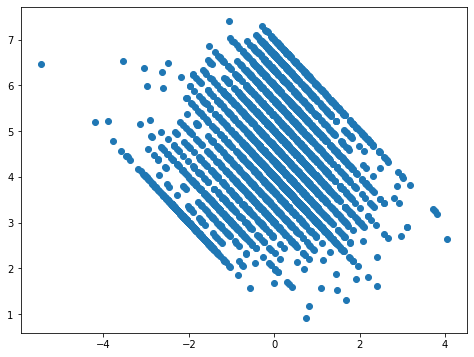

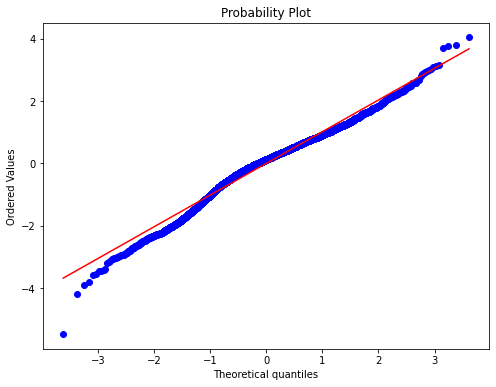

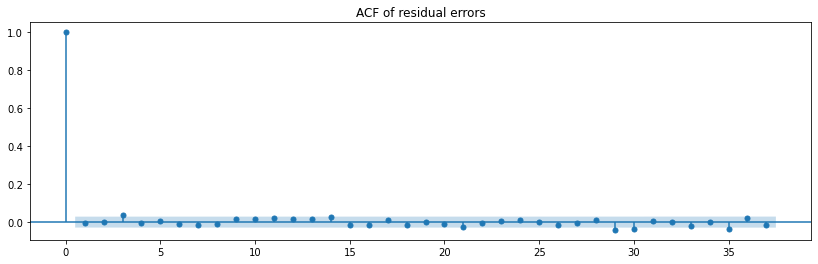

In [18]:
# Normality and autocorrelation of residuals
pred_val = avg_results.fittedvalues.copy()
true_val = y.values.copy()
residual = true_val - pred_val

fig, ax = plt.subplots(figsize=(8,6))
_ = ax.scatter(residual, pred_val)

fig, ax = plt.subplots(figsize=(8,6))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

print(r**2)

plot_acf(avg_results.resid, title='ACF of residual errors')
plt.show()

In [19]:
# Data are normally distributed: Jarque-Bera
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(avg_results.resid)
lzip(name, test)

[('Jarque-Bera', 270.5351896748056),
 ('Chi^2 two-tail prob.', 1.7948575316677315e-59),
 ('Skew', -0.4908733208601444),
 ('Kurtosis', 3.663120156318868)]

In [20]:
# Heteroskedasticity: Breush-Pagan test
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(avg_results.resid, X)
lzip(name, test)

[('Lagrange multiplier statistic', 434.3191161951422),
 ('p-value', 3.44623496627377e-27),
 ('f-value', 3.0081859734082936),
 ('f p-value', 1.6212901761828554e-30)]

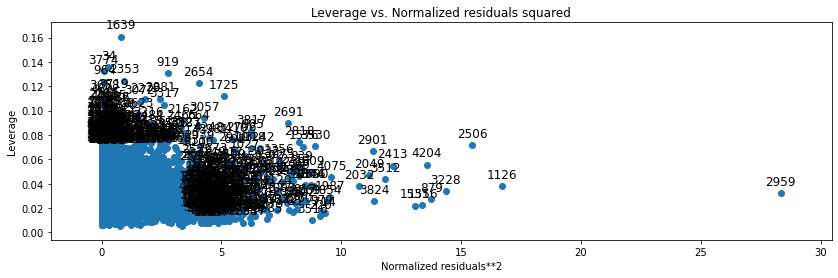

In [21]:
# Leverage/Outliers
sm.graphics.plot_leverage_resid2(avg_results)
plt.show()

In [22]:
y[2959], X.iloc[2959,:].T

(1.0,
 const                                                  1.00
 Call People                                            4.00
 Cleaning                                               6.00
 Cooking                                                4.00
 Crafting                                               5.00
 Create Online Content                                  4.00
 Drugs or Alcohol                                       4.00
 Exercise Indoors                                       7.00
 Exercise Outdoors                                      1.00
 Fashion                                                4.00
 Gardening                                              5.00
 Learning New Skills                                    4.00
 Making Music                                           4.00
 Meditating                                             6.00
 Music Listening                                        4.00
 Online Dating                                          4.00
 Photography      

#### Dependent Variable

<AxesSubplot:xlabel='avg_h', ylabel='Density'>

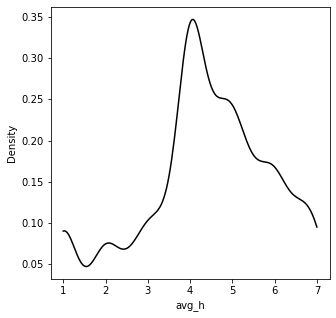

In [23]:
figure, ax = plt.subplots(figsize=(5,5))
sns.distplot(y, color='black',hist=False, kde_kws={"cut": 0})

#### **LightGBM**

In [24]:
h_avg_lgbmr = lgbmr_model(y, X)

0.023147255121330194 % of correlations > 0.90

Best parameters found by grid search are: LGBMRegressor(learning_rate=0.05, max_depth=10, min_child_samples=10,
              num_leaves=40, random_state=123, subsample_for_bin=500)

LightGBM Regression_r2: 0.5364
LightGBM Regression_Mean_squared_error: 1.1228
LightGBM Regression_Mean_absolute_error: 0.792


### **SHAP Plots**
https://github.com/slundberg/shap/blob/master/README.md

SHAP: average of marginal contributions across all permutations. 

In [25]:
# load JS visualization code to notebook
shap.initjs()

regressor = h_avg_lgbmr

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X)

**Mean absolute value of the SHAP values for each feature to get a standard bar plot**

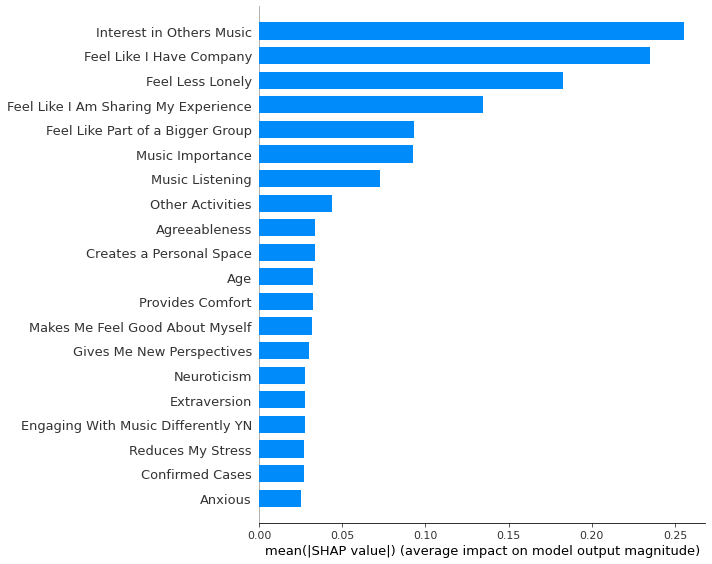

In [26]:
# Simple Feature Importance
shap.summary_plot(shap_values, X, plot_type="bar")

**To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot above sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low).**

In [27]:
X['Feel Like I Have Company'].value_counts(dropna=False, normalize=True).sort_index().round(4)*100

1.0     2.85
2.0     2.36
3.0     4.35
4.0    51.43
5.0    12.47
6.0    14.61
7.0    11.93
Name: Feel Like I Have Company, dtype: float64

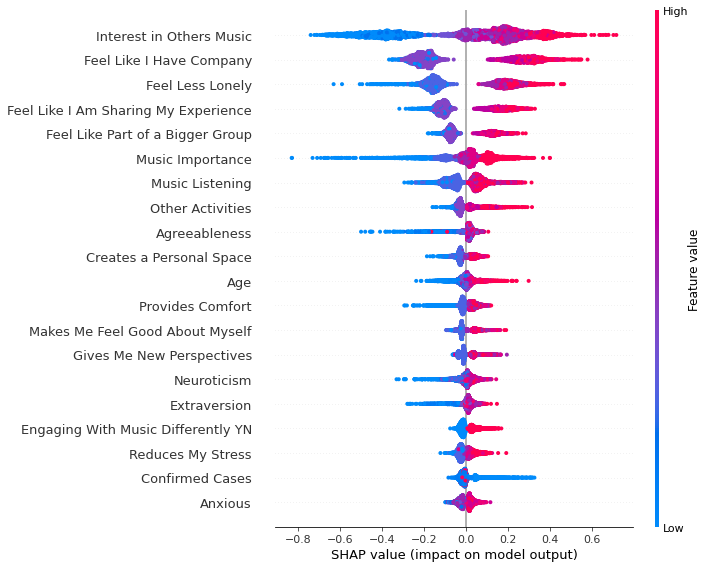

In [28]:
# Shap plot -- summarize the effects of ALL features
shap.summary_plot(shap_values, X, show=False)
f = plt.gcf()
f.savefig('shap_music_listening.png', dpi=300)

In [29]:
top_features = ['Interest in Others Music',
                'Feel Like I Have Company',
                'Feel Less Lonely',
                'Feel Like I Am Sharing My Experience',
                'Feel Like Part of a Bigger Group',
                'Music Importance',
                'Music Listening',
                'Other Activities',
                'Agreeableness',
                'Creates a Personal Space',
                'Age',
                'Provides Comfort',
                'Makes Me Feel Good About Myself',
                'Gives Me New Perspectives',
                'Neuroticism',
                'Extraversion',
                'Engaging With Music Differently YN',
                'Reduces My Stress',
                'Confirmed Cases',
                'Anxious'
               ]

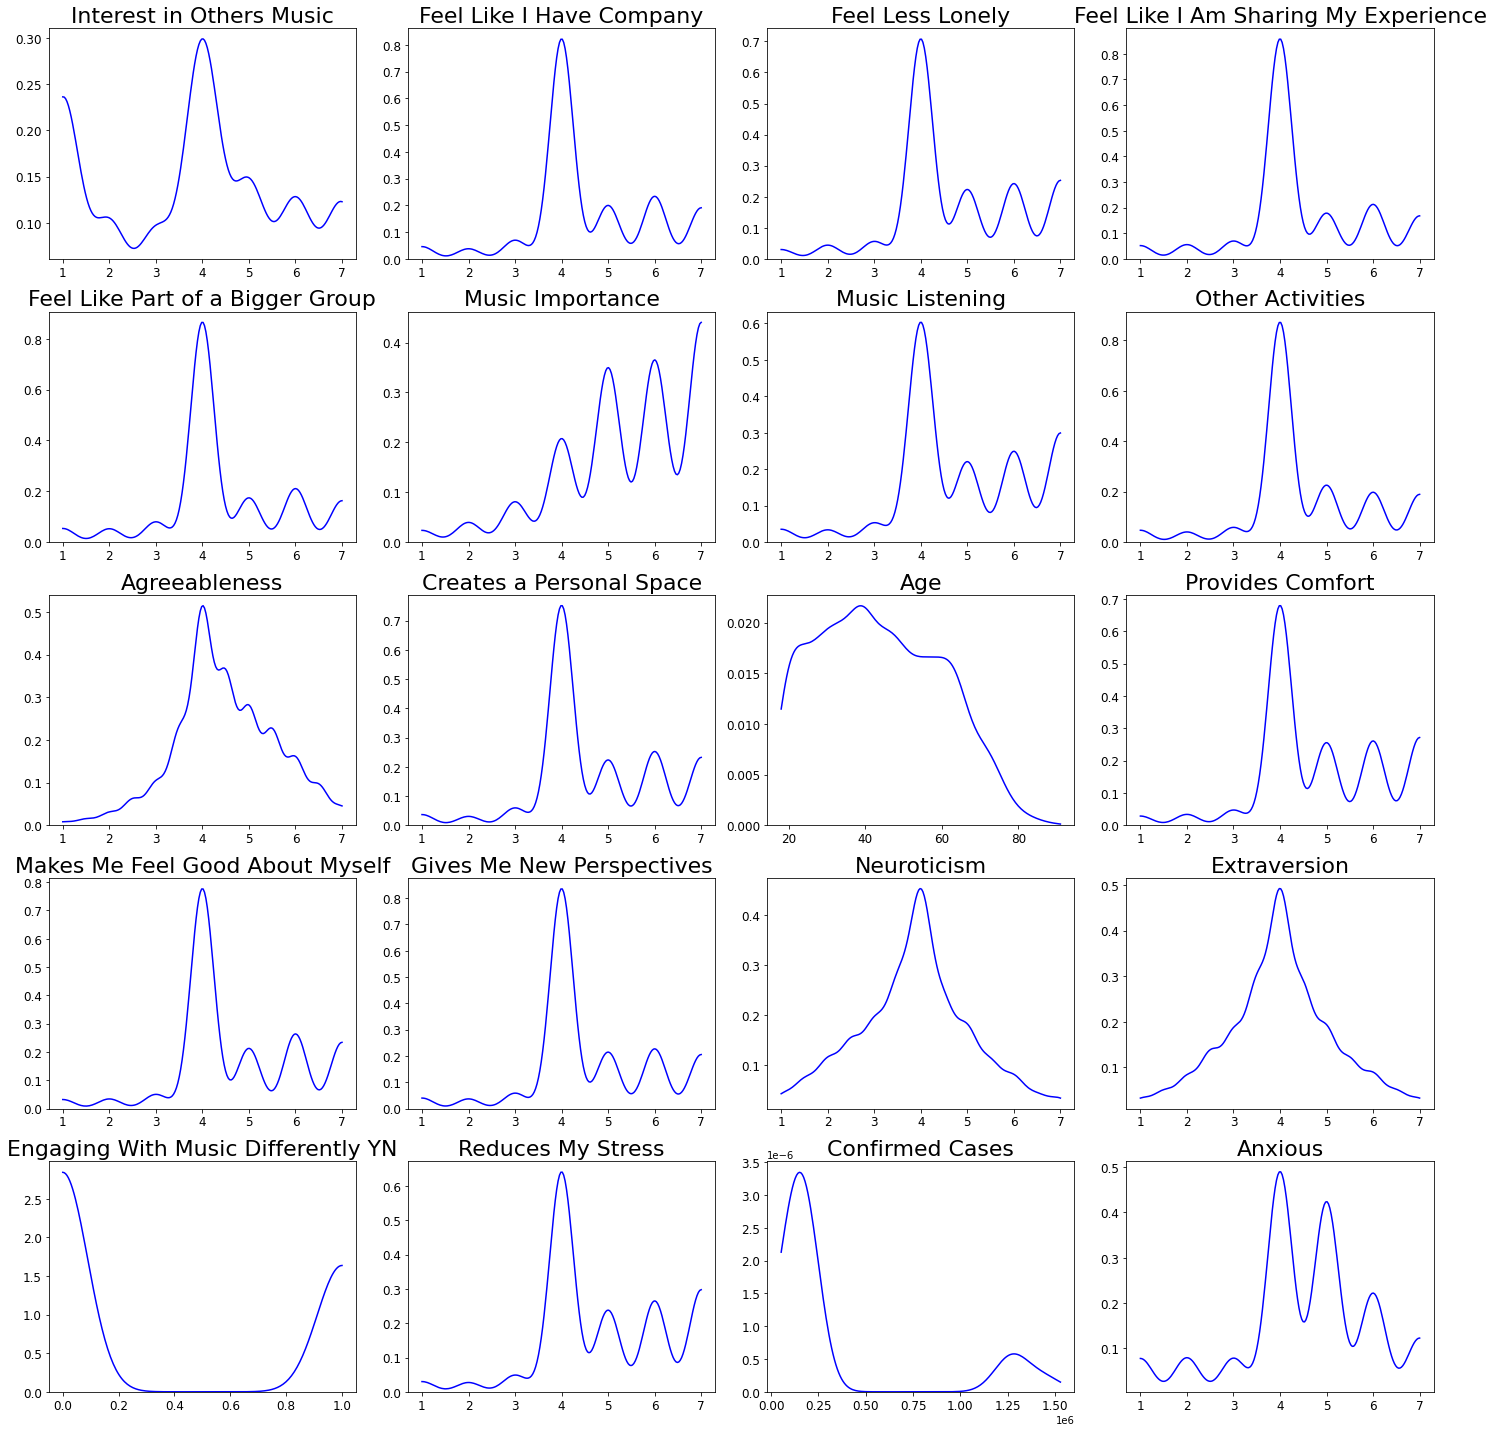

In [30]:
# distributions of top variables (like a histogram)
plt.figure(figsize=(20,20))
for i, column in enumerate(top_features):
    plt.subplot(5, 4, i+1)
    sns.distplot(X[column], color = 'b', hist = False, kde_kws={"cut": 0})
    plt.title(column, size = 22)
    plt.ylabel('')
    plt.xlabel('')
    plt.tight_layout()
    plt.tick_params(axis='both', which='major', labelsize=12)

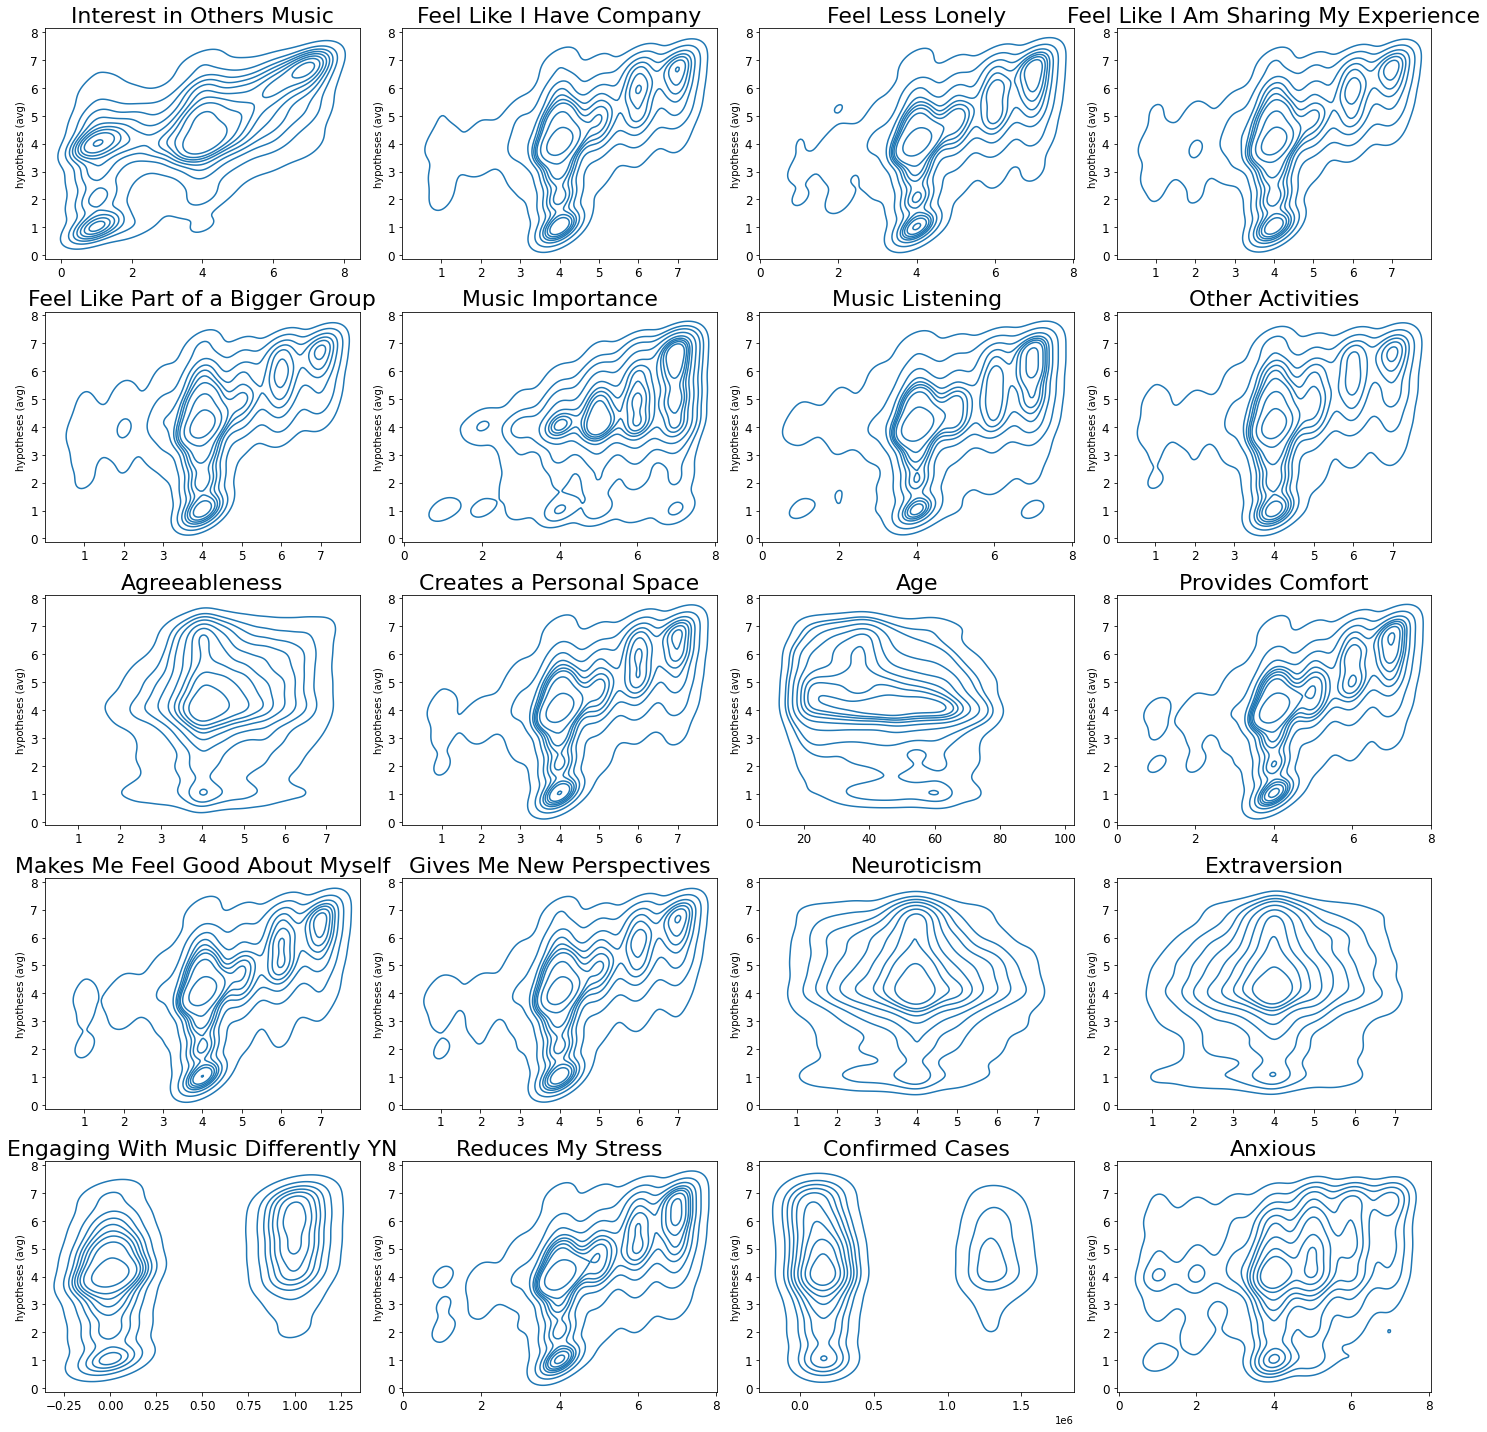

In [31]:
# density plot comparing how the top features vary with the dependent variable (avg of the hypotheses)
plt.figure(figsize=(20,20))
for i, column in enumerate(top_features):
    plt.subplot(5, 4, i+1)
    sns.kdeplot(x=X[column], y=y)
    plt.title(column, size = 22)
    plt.ylabel('hypotheses (avg)')
    plt.xlabel('')
    plt.tight_layout()
    plt.tick_params(axis='both', which='major', labelsize=12)